Building on the tutorial at https://pyro.ai/examples/sir_hmc.html, the folks at Pyro created an additional interface for SIR modeling that compresses much of the info that that tutorial provided into a concrete interface for compartmental modeling. Below is that work, drawn from http://pyro.ai/examples/epi_intro.html

This is my second notebook in this "series". Will again use the compartmental model, but this time for SEIR modeling. Due to difficulty in finding this data in the real world (not to mention how hard it was to model in SIR to begin with), I'll stick with synthetic data for now. Using MCMC and SVI methods to estimate epidemic parameters and see if intervention helps, and to what extent. 

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [2]:
pyro.__version__

'1.5.1'

In [19]:
class SimpleSEI3RModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered-Dead model.

    To customize this model we recommend forking and editing this class.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected, "D"
    for deceased individuals, and "R" for recovered individuals (the recovered
    individuals are implicit: ``R = population - S - E - I - D``) with
    transitions ``S -> E -> I -> R`` and ``I -> D``.

    Because the transitions are not simple linear succession, this model
    implements a custom :meth:`compute_flows()` method.

    :param int population: Total ``population = S + E + I + R + D``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param float mortality_rate: Portion of infections resulting in death.
        Must be in the open interval ``(0, 1)``.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time, recovery_time,
                 mortality_rate, data):
        compartments = ("S", "E", "I", "I2", "I3", "D")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        assert isinstance(mortality_rate, float)
        assert 0 < mortality_rate < 1
        self.mortality_rate = mortality_rate

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        mu = self.mortality_rate
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        return R0, tau_e, tau_i, mu, rho

    def initialize(self, params):
        # Start with a single infection ( at stage 1) .
        return {"S": self.population - 1, "E": 0, "I": 1, "I2":0, "I3":0, "D": 0}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, mu, rho = params # add the other ones from paper
        p1 = .5
        p2 = .5
        gamma1 = .2
        gamma2 = .3
        gamma3 = .5
        kappa = 0.005

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=R0 / tau_i,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        
        I2I2 = pyro.sample("I2I2_{}".format(t),
                          binomial_dist(state["I"], p1))
        
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], gamma1))
       
        I22I3 = pyro.sample("I22I3_{}".format(t),
                          binomial_dist(state["I2"], p2))
        
        I22R = pyro.sample("I22R_{}".format(t),
                          binomial_dist(state["I2"], gamma2))
        
        
        I32R = pyro.sample("I32R_{}".format(t),
                          binomial_dist(state["I3"], gamma3))
        
        I32D = pyro.sample("I32D_{}".format(t),
                          binomial_dist(state["I3"], kappa))
        
        
        # Of the 1/tau_i expected recoveries-or-deaths, a portion mu die and
        # the remaining recover. Alternatively we could model this with a
        # Multinomial distribution I2_ and extract the two components I2D and
        # I2R, however the Multinomial distribution does not currently
        # implement overdispersion or moment matching.
        

        
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R - I2I2
        state["I2"] = state["I2"] + I2I2 - I22R - I22I3
        state["I3"] = state["I3"] + I22I3 - I32R - I32D

        state["D"] = state["D"] + I32D
        
        
        
        

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)

    def compute_flows(self, prev, curr, t):
        
        # First part
        S2E = prev["S"] - curr["S"]  # S can only go to E.
        E2I = prev["E"] - curr["E"] + S2E
        
        # Flow for I
        I2R =  prev["I"] - curr["I"] + E2I - I2I2
        I2I2 = prev["I"] - curr["I"] + E2I - I2R
        
        # Flow for I2
        I22R = prev["I2"] - curr["I2"] + I2I2 - I22I3
        I22I3 = prev["I2"] - curr["I2"] + I2I2 - I22R 
        
        
        # Flow for I3
        I32D = curr["D"] - prev["D"]  # D can only have come from I3. 
        I32R = prev["I3"] - curr["I3"] + I22I3 - I32D

        
        
        return {
            "S2E_{}".format(t): S2E,
            "E2I_{}".format(t): E2I,
            "I2I2_{}".format(t): I2I2,
            "I22I3_{}".format(t): I22I3,

            "I32D_{}".format(t): I32D,
            "I2R_{}".format(t): I2R,
            "I22R_{}".format(t): I22R,
            "I32R_{}".format(t): I32R,

        }



In [20]:
class SimpleSEIRDModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered-Dead model.

    To customize this model we recommend forking and editing this class.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected, "D"
    for deceased individuals, and "R" for recovered individuals (the recovered
    individuals are implicit: ``R = population - S - E - I - D``) with
    transitions ``S -> E -> I -> R`` and ``I -> D``.

    Because the transitions are not simple linear succession, this model
    implements a custom :meth:`compute_flows()` method.

    :param int population: Total ``population = S + E + I + R + D``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param float mortality_rate: Portion of infections resulting in death.
        Must be in the open interval ``(0, 1)``.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time, recovery_time,
                 mortality_rate, data):
        compartments = ("S", "E", "I", "D")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        assert isinstance(mortality_rate, float)
        assert 0 < mortality_rate < 1
        self.mortality_rate = mortality_rate

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        mu = self.mortality_rate
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        return R0, tau_e, tau_i, mu, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1, "D": 0}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, mu, rho = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=R0 / tau_i,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        # Of the 1/tau_i expected recoveries-or-deaths, a portion mu die and
        # the remaining recover. Alternatively we could model this with a
        # Multinomial distribution I2_ and extract the two components I2D and
        # I2R, however the Multinomial distribution does not currently
        # implement overdispersion or moment matching.
        
        # Implicit part, and split flow. Will get much more complicated here when I include the multiple I values!
        
        I2D = pyro.sample("I2D_{}".format(t),
                          binomial_dist(state["I"], mu / tau_i))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"] - I2D, 1 / tau_i))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R - I2D
        state["D"] = state["D"] + I2D

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)

    def compute_flows(self, prev, curr, t):
        S2E = prev["S"] - curr["S"]  # S can only go to E.
        I2D = curr["D"] - prev["D"]  # D can only have come from I.
        # We deduce the remaining flows by conservation of mass:
        #   curr - prev = inflows - outflows
        E2I = prev["E"] - curr["E"] + S2E
        I2R = prev["I"] - curr["I"] + E2I - I2D
        return {
            "S2E_{}".format(t): S2E,
            "E2I_{}".format(t): E2I,
            "I2D_{}".format(t): I2D,
            "I2R_{}".format(t): I2R,
        }

## Generating Data

What if I don't want to do this? 

In [28]:
population = 10000
recovery_time = 10.
incubation_time = 3.
empty_data = [None] * 150
mortality_rate = .004 
model = SimpleSEI3RModel(population, incubation_time, recovery_time, mortality_rate, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 20.2})
    total_infections = synth_data["S2E"].sum().item()
    print("total exposed:", total_infections)
    if 400 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


total exposed: 9315.0
total exposed: 9316.0
total exposed: 9323.0
total exposed: 9381.0
total exposed: 9302.0
total exposed: 9330.0
total exposed: 9330.0


KeyboardInterrupt: 

For the model to work, it requires S, S2I, I, I2R, obs (noisy S2I), R0, and rho. 


At the moment, all of these things are synthetically generated, after we first specify R0, rho and population. 

For real world, I'll try this now, but we set:

S2I = obs, and use reported values for the others. In essence we no longer use the noisy observations and assume whatever is reported is right? 

I'm not sure if the model will work if we do not specify R0 or rho, so will have to try this and find out. 

In [29]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))
    

D.shape = (150,)
E.shape = (150,)
E2I.shape = (150,)
I.shape = (150,)
I2.shape = (150,)
I22I3.shape = (150,)
I22R.shape = (150,)
I2I2.shape = (150,)
I2R.shape = (150,)
I3.shape = (150,)
I32D.shape = (150,)
I32R.shape = (150,)
R0.shape = ()
S.shape = (150,)
S2E.shape = (150,)
obs.shape = (150,)
rho.shape = ()


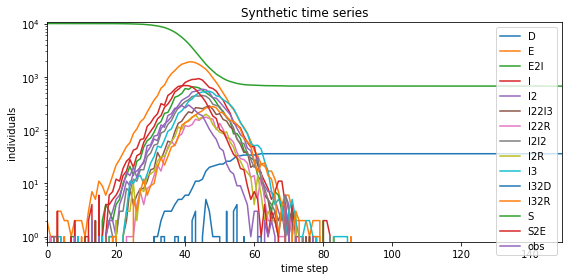

In [30]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

## Inference

In [32]:
# what if we only have obs? can we estimate using just that? 
obs = synth_data["obs"]
model = SimpleSEI3RModel(population, incubation_time, recovery_time, mortality_rate, obs) 


In [33]:
obs.shape

torch.Size([150])

In [34]:
%%time
losses = model.fit_svi(num_steps=101 if smoke_test else 2001,
                       jit=True)

UnboundLocalError: local variable 'I2I2' referenced before assignment

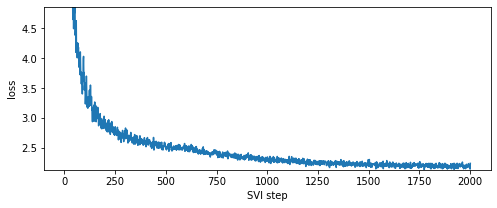

In [10]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.ylim(min(losses), max(losses[50:]));

In [11]:
for key, value in sorted(model.samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

R0.shape = (100, 1)
auxiliary.shape = (100, 1, 4, 150)
rho.shape = (100, 1)


In [12]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 150 time steps...


CPU times: user 464 ms, sys: 6 ms, total: 470 ms
Wall time: 472 ms


/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


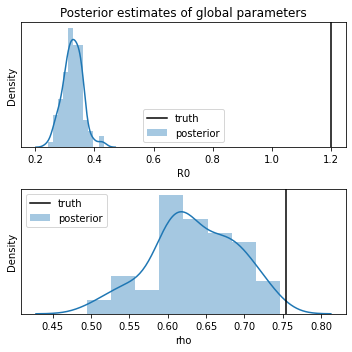

In [13]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


## MCMC

In [14]:
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 200,
                      jit_compile=True,)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [00:52,  7.61it/s, step size=2.13e-02, acc. prob=0.844]


## Prediction

In [15]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 150 time steps...


CPU times: user 473 ms, sys: 7.99 ms, total: 481 ms
Wall time: 485 ms


In [16]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

D.shape = (200, 150)
E.shape = (200, 150)
E2I.shape = (200, 150)
I.shape = (200, 150)
I2D.shape = (200, 150)
I2R.shape = (200, 150)
R0.shape = (200, 1)
S.shape = (200, 150)
S2E.shape = (200, 150)
auxiliary.shape = (200, 1, 4, 150)
obs.shape = (200, 150)
rho.shape = (200, 1)


/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


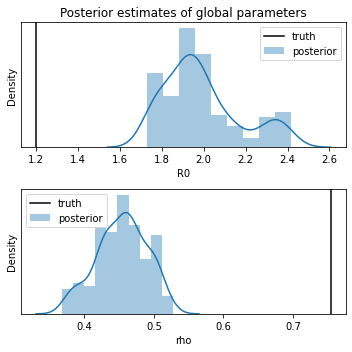

In [17]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


## Forecasting

In [18]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 150 time steps...


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


INFO 	 Forecasting 30 steps ahead...


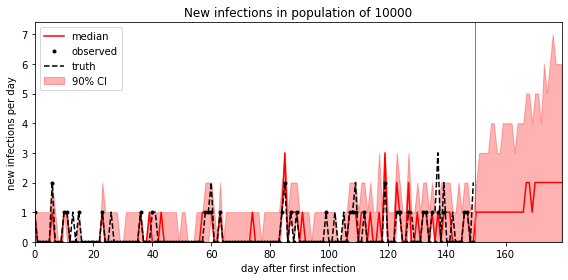

In [19]:

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2E = samples["S2E"]
    median = S2E.median(dim=0).values
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)

A suggestion of the authors is to use MCMC rather than SVI to estimate, and this will produce better results with only a little longer compute time. I will avoid doing that for the moment, because I would consider it a higher priority to figure out how to run this model with actual data, rather than manufactured. 

In [ ]:
synth_data

In [ ]:
samples['R0'].mean()